<a href="https://colab.research.google.com/github/Sri-vatsa/AddressApp/blob/master/experimental_code/October16_2020/time_series_experiments/Transformers_timeseries_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install pydot

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from scipy import signal
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot

# Dummy data


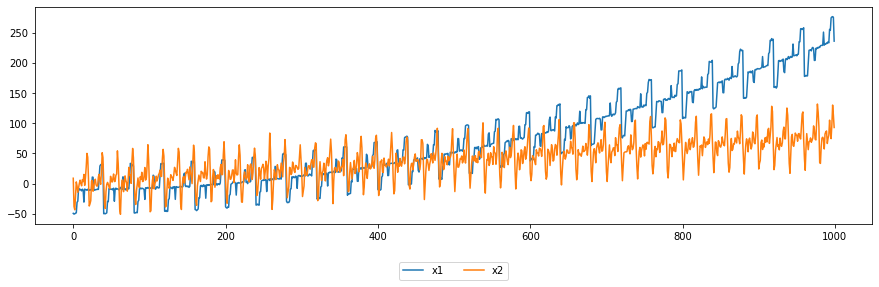

In [23]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([10*signal.square(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 1, n_)
#x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Preprocess dummy data

In [24]:
# Split train-test
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


In [25]:
# Detrending 
x_index = np.array(range(len(t)))

x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)


[ 2.45784380e-04  4.79917259e-03 -1.16002066e+01]
[ 0.08097356 -0.86977414]


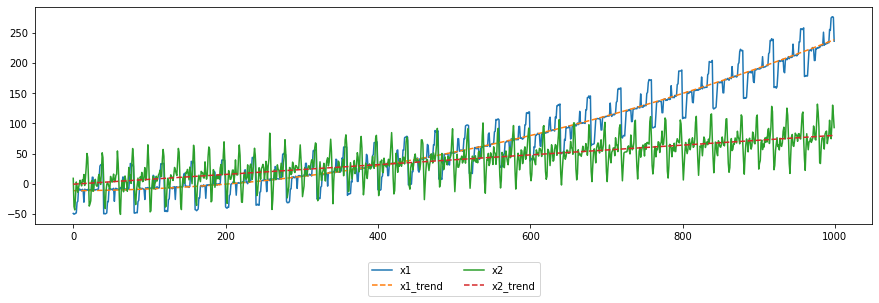

In [26]:
# Get Trendlines for each
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

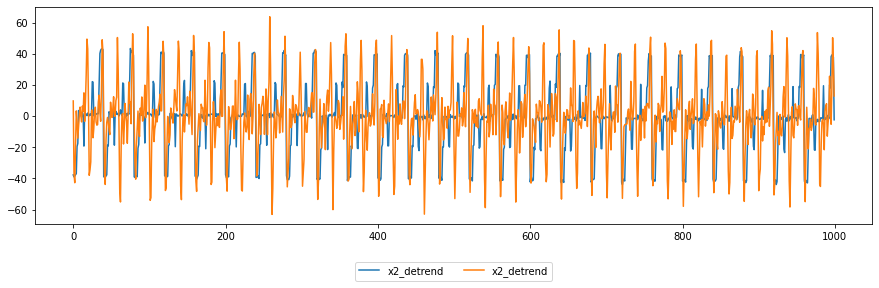

In [27]:
# Deduct the trends
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [28]:
# Combine sequences
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

# Normalize
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

(1000, 4)
[[-37.73467003   9.73505627   0.           1.        ]
 [-38.99447047 -37.20058572   1.           1.        ]
 [-38.49187994 -42.75301472   2.           1.        ]
 ...
 [ 39.2601804   50.31262432 997.           0.        ]
 [ 37.7044678   33.43156921 998.           0.        ]
 [ -2.36459076  12.93745853 999.           0.        ]]
[43.40582413398309, 63.78138879774979, 1, 1]
[[-8.69345780e-01  1.52631613e-01  0.00000000e+00  1.00000000e+00]
 [-8.98369545e-01 -5.83251422e-01  1.00000000e+00  1.00000000e+00]
 [-8.86790672e-01 -6.70305484e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 9.04491072e-01  7.88829238e-01  9.97000000e+02  0.00000000e+00]
 [ 8.68649969e-01  5.24158690e-01  9.98000000e+02  0.00000000e+00]
 [-5.44763474e-02  2.02840653e-01  9.99000000e+02  0.00000000e+00]]


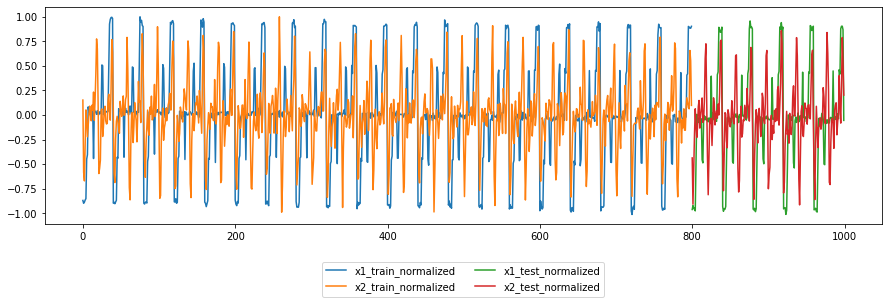

In [29]:
# Plot normalized data
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [30]:
# Truncate full sequence into sliding windows of 200 timesteps input and 20 timesteps output
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


Final data ready to be used by models

In [31]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

# 3 dims refer to: detrended and normalised x1, detrended and normalised x2, and 
# original assigned data position index. Only the first 2 features will be used for training


(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [32]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


# Model 1: Transformer (LSTM) - No Skip Connections


In [33]:
n_hidden = 100

In [34]:
# Encoder LSTM
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

Tensor("lstm/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm/while:5", shape=(None, 100), dtype=float32)


In [35]:
# Decoder LSTM
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("repeat_vector/Tile:0", shape=(None, 20, 100), dtype=float32)
Tensor("lstm_1/transpose_1:0", shape=(None, 20, 100), dtype=float32)


In [36]:
# Attention layer
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)#
print(attention)

Tensor("activation/truediv:0", shape=(None, 20, 200), dtype=float32)


In [37]:
# Get context vector
context = dot([attention, encoder_stack_h], axes=[2,1])#
context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(None, 20, 100), dtype=float32)


In [38]:
# Concat context and hiddent states
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate/concat:0", shape=(None, 20, 200), dtype=float32)


In [39]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)
# TimeDistributed is wrapper for dense to make sure ops are done for each timestep. From 2.0 onwards, Dense/TimeDistributed kinda do the same thing.https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras/47309453#47309453 

Tensor("time_distributed/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [40]:
model1 = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model1.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 100), ( 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][1]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Model 2: Transformer(GRU) - No Skip Connections

In [41]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

In [42]:
# Encoder GRU
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)

Tensor("gru/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("gru/while:4", shape=(None, 100), dtype=float32)


In [43]:
# Decoder GRU
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

decoder_stack_h = GRU(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h])
print(decoder_stack_h)

Tensor("repeat_vector_1/Tile:0", shape=(None, 20, 100), dtype=float32)
Tensor("gru_1/transpose_1:0", shape=(None, 20, 100), dtype=float32)


In [44]:
# Attention layer
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation_1/truediv:0", shape=(None, 20, 200), dtype=float32)


In [45]:
# Get context vector
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(None, 20, 100), dtype=float32)


In [46]:
# Concat context and hiddent states
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate_1/concat:0", shape=(None, 20, 200), dtype=float32)


In [47]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)
# TimeDistributed is wrapper for dense to make sure ops are done for each timestep. From 2.0 onwards, Dense/TimeDistributed kinda do the same thing.https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras/47309453#47309453 

Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [48]:
model2 = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 200, 100), ( 31200       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 100)          400         gru[0][1]                        
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_3[0][0]      
_______________________________________________________________________________________

# Training 

In [49]:
total_epochs = 40

In [50]:
# Train LSTM Transformer
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model1.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=total_epochs, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae_lstm = history.history['mae']
valid_mae_lstm = history.history['val_mae']
 
model1.save('transformer_LSTM.h5')

Epoch 1/40
5/5 [==============================] - 3s 626ms/step - loss: 4.8434 - mae: 1.0167 - val_loss: 0.1821 - val_mae: 0.2998
Epoch 2/40
5/5 [==============================] - 3s 527ms/step - loss: 0.4867 - mae: 0.4980 - val_loss: 0.4156 - val_mae: 0.5157
Epoch 3/40
5/5 [==============================] - 3s 518ms/step - loss: 0.2004 - mae: 0.3385 - val_loss: 0.2088 - val_mae: 0.3497
Epoch 4/40
5/5 [==============================] - 3s 524ms/step - loss: 0.1792 - mae: 0.3097 - val_loss: 0.2485 - val_mae: 0.4097
Epoch 5/40
5/5 [==============================] - 3s 520ms/step - loss: 0.1675 - mae: 0.2950 - val_loss: 0.1608 - val_mae: 0.2948
Epoch 6/40
5/5 [==============================] - 3s 527ms/step - loss: 0.1596 - mae: 0.2890 - val_loss: 0.1439 - val_mae: 0.2711
Epoch 7/40
5/5 [==============================] - 3s 512ms/step - loss: 0.1512 - mae: 0.2810 - val_loss: 0.1361 - val_mae: 0.2691
Epoch 8/40
5/5 [==============================] - 3s 505ms/step - loss: 0.1441 - mae: 0.27

In [51]:
# Train GRU Transformer
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model2.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=total_epochs, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae_gru = history.history['mae']
valid_mae_gru = history.history['val_mae']
 
model2.save('transformer_GRU.h5')

Epoch 1/40
5/5 [==============================] - 3s 554ms/step - loss: 2.1251 - mae: 0.9712 - val_loss: 0.2190 - val_mae: 0.3582
Epoch 2/40
5/5 [==============================] - 2s 441ms/step - loss: 0.4959 - mae: 0.5254 - val_loss: 0.2447 - val_mae: 0.3884
Epoch 3/40
5/5 [==============================] - 2s 437ms/step - loss: 0.2376 - mae: 0.3668 - val_loss: 0.2631 - val_mae: 0.4047
Epoch 4/40
5/5 [==============================] - 2s 432ms/step - loss: 0.2028 - mae: 0.3323 - val_loss: 0.2038 - val_mae: 0.3563
Epoch 5/40
5/5 [==============================] - 2s 433ms/step - loss: 0.1826 - mae: 0.3097 - val_loss: 0.1786 - val_mae: 0.3081
Epoch 6/40
5/5 [==============================] - 2s 433ms/step - loss: 0.1811 - mae: 0.3107 - val_loss: 0.1668 - val_mae: 0.2918
Epoch 7/40
5/5 [==============================] - 2s 438ms/step - loss: 0.1743 - mae: 0.2989 - val_loss: 0.1663 - val_mae: 0.2958
Epoch 8/40
5/5 [==============================] - 2s 432ms/step - loss: 0.1699 - mae: 0.29

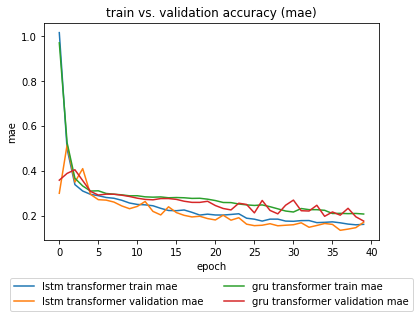

In [52]:
# Plot training stats
plt.plot(train_mae_lstm, label='lstm transformer train mae'), 
plt.plot(valid_mae_lstm, label='lstm transformer validation mae')
plt.plot(train_mae_gru, label='gru transformer train mae'), 
plt.plot(valid_mae_gru, label='gru transformer validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Prediction

## Transformer LSTM Prediction

In [55]:
train_pred_detrend = model1.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model1.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)


train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)
(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)
train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


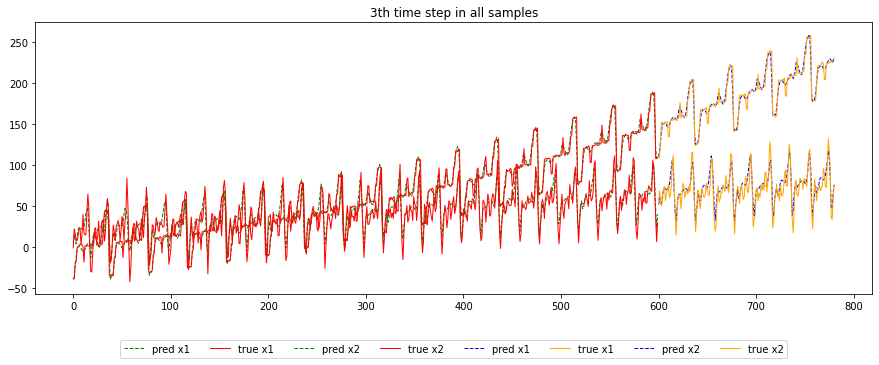

In [56]:
ith_timestep = random.choice(range(data_final[lb].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

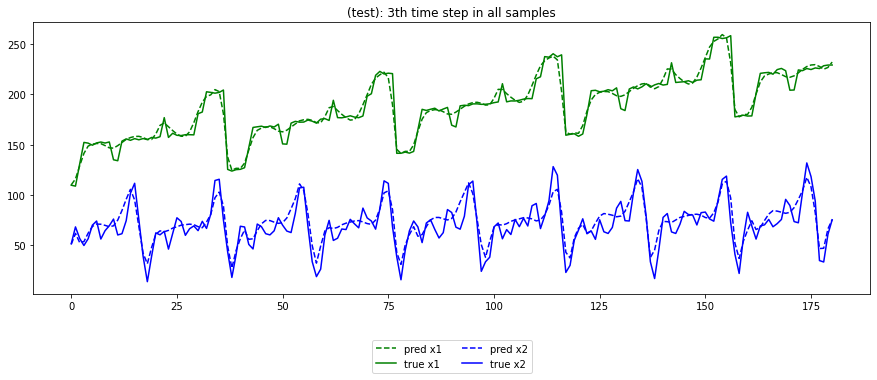

In [57]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Transformer GRU Prediction

In [58]:
train_pred_detrend = model2.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model2.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)


train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)
(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)
train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


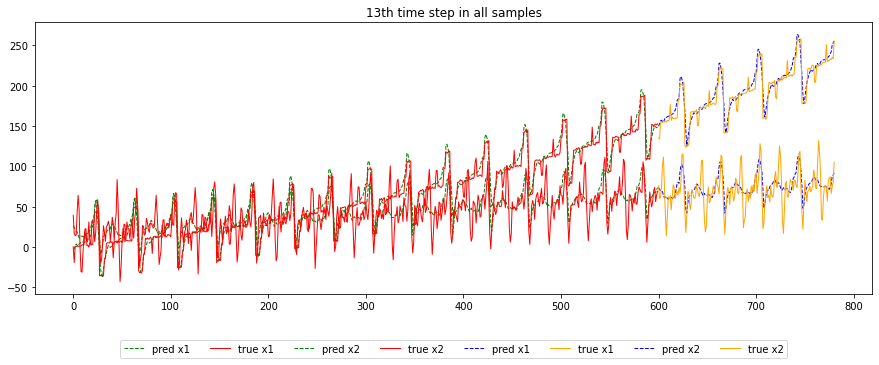

In [59]:
ith_timestep = random.choice(range(data_final[lb].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

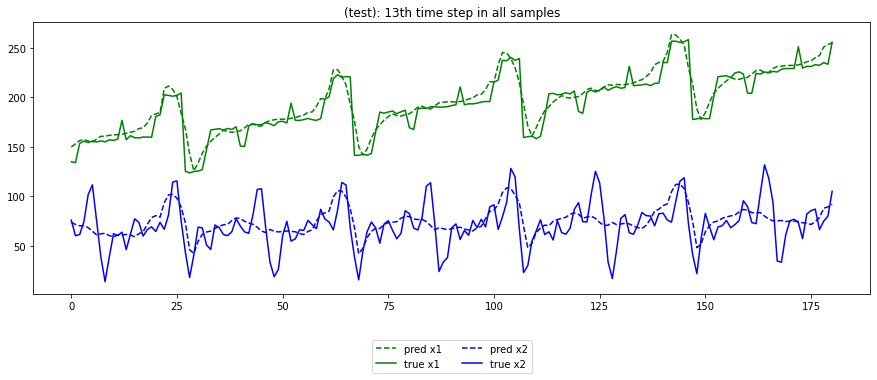

In [60]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()